In [1]:
%%capture
%run ../config/config.ipynb
%run ./Transformer.ipynb
%run ../utils/attn-map.ipynb

In [2]:
import torch

In [3]:
# import the model in the models/ directory 
model_name = "model_2024_11_20_epoch_2"
model_path = model_dir / model_name

In [4]:
# Load the trained model 
model = Transformer(
    src_pad_token=src_pad_token, 
    trg_pad_token=trg_pad_token, 
    enc_voc_size=enc_voc_size, 
    dec_voc_size=dec_voc_size, 
    n_head=n_head, 
    max_len=max_len, 
    d_model=d_model, 
    ffn_hidden=ffn_hidden, 
    n_layers=n_layers, 
    drop_prob=drop_prob, 
    device=device).to(device)

# load weights from the saved model 
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))
model.eval()

Transformer(
  (emb): TransformerEmbedding(
    (token_emb): TokenEmbeddings(65001, 256, padding_idx=65000)
    (position_emb): PositionalEncoding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (emb): TransformerEmbedding(
      (token_emb): TokenEmbeddings(65001, 256, padding_idx=65000)
      (position_emb): PositionalEncoding()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (attention): MultiHeadAttentionBlock(
          (attention): AttentionBlock(
            (softmax): Softmax(dim=-1)
          )
          (Wq): Linear(in_features=256, out_features=256, bias=True)
          (Wk): Linear(in_features=256, out_features=256, bias=True)
          (Wv): Linear(in_features=256, out_features=256, bias=True)
          (Wconcat): Linear(in_features=256, out_features=256, bias=True)
        )
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0

In [5]:
# define a helper function 
def tensor2tokenid(tensor): 
    # convert tensor to tokenid 
    # by picking index that has max value 
    # use argmax 
    token_id = torch.argmax(tensor, dim=-1)
    return token_id

In [6]:
tmp = kr_tokenizer("안녕하세요", add_special_tokens=True, padding="max_length", max_length=max_len, truncation=True).input_ids 


In [6]:
# Create a inference function that takes korean sentence, and outputs english sentence.
# for generating english sentence, we are going to limit the output token length by limit_token_length
def inference(kr_sentence): 
    with torch.no_grad():
        limit_token_length = max_len - 1
        # since we are going to generete English sentence in autoregressive manner, 
        # we have to define the starting point.
        # make a max_len length tensor that first element is trg_sos_token, 
        # and others filled with trg_pad_token
        # reshape to set batch_size as 1 
        trg_token_ids = en_tokenizer.encode('</s>', return_tensors="pt", add_special_tokens=False).to(device)
        # trg_token_ids[0] = trg_eos_token
        trg_token_ids = trg_token_ids.reshape((1, -1)).to(device)
        print(trg_token_ids.shape)
        # print(trg_token_ids.type())
        
        # tokenize src sentence 
        src_token_ids = kr_tokenizer(kr_sentence, add_special_tokens=True, padding="max_length", max_length=max_len, truncation=True).input_ids

        src_tokens = kr_tokenizer.convert_ids_to_tokens(src_token_ids)
        
        src_token_ids = torch.tensor(src_token_ids).reshape((1, -1)).to(device)
        # print(src_token_ids.shape)
        # print(src_token_ids.type())
        
        # make src_mask and trg_mask
        src_mask = model.make_src_mask(src_token_ids)
        # print(src_mask)
    
        # get enc_src using model.encoder 
        # we can use whole transformer iteratively, but 
        # since we are going to reuse enc_src, 
        # we are going to cache it, and reuse it
        enc_src, enc_self_attn_map = model.encoder(src_token_ids, src_mask)

        # draw attn_map for enc_self_attn_map
        draw_one_attention_map(0, enc_self_attn_map, src_tokens, src_tokens)
        
        for idx in range(1, limit_token_length): 
            trg_mask = model.make_trg_mask(trg_token_ids)
            # print(trg_mask)
            # print(f'trg_token_ids: {trg_token_ids.shape}')
            # print(f'model.decoder(trg_token_ids, enc_src, trg_mask, src_mask)[0] shape: {model.decoder(trg_token_ids, enc_src, trg_mask, src_mask)[0].shape}')
            decoded, dec_self_attn_map, enc_dec_attn_map = model.decoder(trg_token_ids, enc_src, trg_mask, src_mask)
            next_token_tensor = decoded[0, -1, :]
            # print(f'next_token_tensor shape: {next_token_tensor.shape}')
            next_token_id = tensor2tokenid(next_token_tensor)
            # print(f'next_token_id: {next_token_id}')
    
            # append it to the trg 
            # print(f'trg_token_ids shape: {trg_token_ids.shape}')
            # print(f'next_token_id.reshape(1, -1) shape: {next_token_id.reshape(1, -1).shape}')
            trg_token_ids = torch.cat([trg_token_ids, next_token_id.reshape(1, -1)], dim=1)
            
            # break if next_token_id is end token 
            if next_token_id == trg_eos_token: 
                break

        print(f'shape of trg_token_ids: {trg_token_ids.shape}')
        trg_tokens = en_tokenizer.convert_ids_to_tokens(trg_token_ids.squeeze(0).tolist())

        print(f'shape of dec_self_attn_map: {dec_self_attn_map.shape}')
        print(f'shape of enc_dec_attn_map: {enc_dec_attn_map}')

        draw_one_attention_map(0, dec_self_attn_map, trg_tokens, trg_tokens)
        draw_one_attention_map(0, enc_dec_attn_map, trg_tokens, src_tokens)
    
        # convert trg into string 
        print(f'{trg_token_ids.reshape(-1)}')
        return en_tokenizer.decode(trg_token_ids.reshape(-1), skip_special_tokens=False)

torch.Size([1, 1])
att_weight for first batch, first head, first query: 1.0
att_weight for first batch, first head, first query: 1.0
att_weight for first batch, first head, first query: 1.0


/Users/ball/Documents/workspace/transformer-tutorial/.venv/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) AppleGothic.
  fig.canvas.draw()
/var/folders/qc/krghrss90j3_h3x_kbbgxj740000gn/T/ipykernel_65554/45132878.py:38: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/ball/Documents/workspace/transformer-tutorial/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


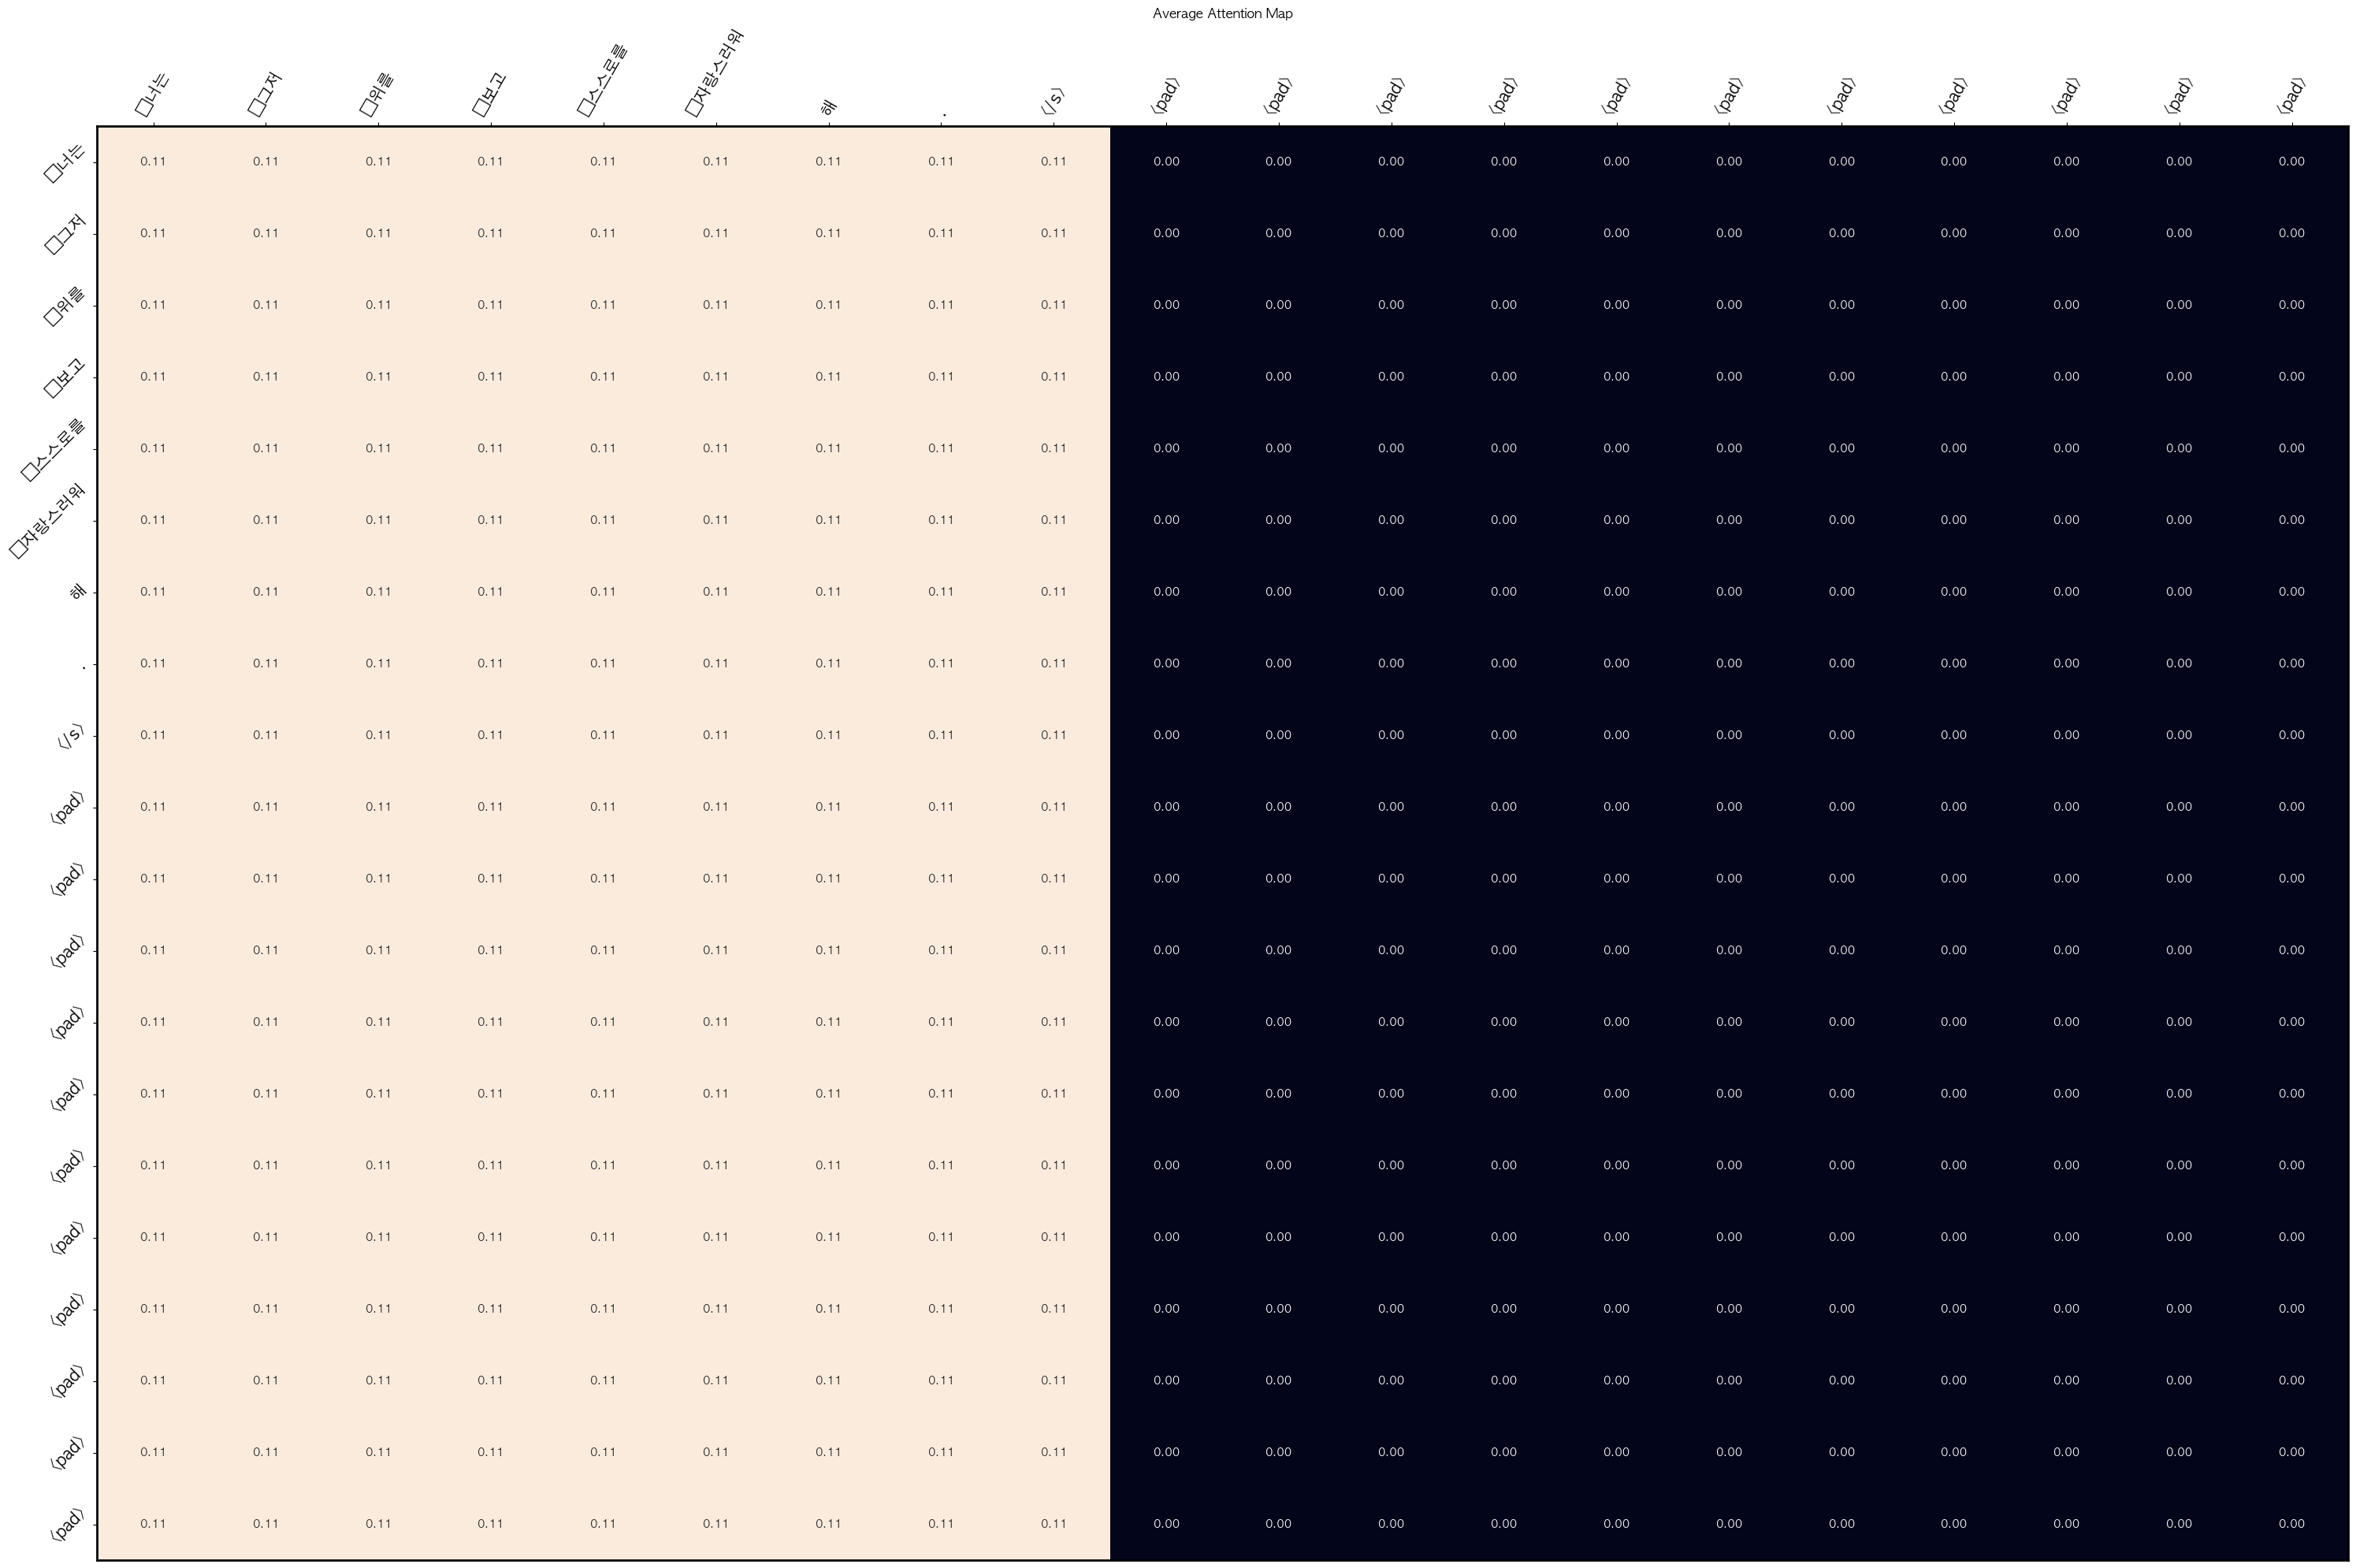

att_weight for first batch, first head, first query: 1.0
att_weight for first batch, first head, first query: 1.0
att_weight for first batch, first head, first query: 1.0
att_weight for first batch, first head, first query: 1.0
att_weight for first batch, first head, first query: 1.0
att_weight for first batch, first head, first query: 1.0
att_weight for first batch, first head, first query: 1.0
att_weight for first batch, first head, first query: 1.0
att_weight for first batch, first head, first query: 1.0
att_weight for first batch, first head, first query: 1.0
att_weight for first batch, first head, first query: 1.0
att_weight for first batch, first head, first query: 1.0
att_weight for first batch, first head, first query: 1.0
att_weight for first batch, first head, first query: 1.0
att_weight for first batch, first head, first query: 1.0
att_weight for first batch, first head, first query: 1.0
att_weight for first batch, first head, first query: 1.0
att_weight for first batch, fir

/Users/ball/Documents/workspace/transformer-tutorial/.venv/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) AppleGothic.
  fig.canvas.draw()
/var/folders/qc/krghrss90j3_h3x_kbbgxj740000gn/T/ipykernel_65554/45132878.py:38: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/ball/Documents/workspace/transformer-tutorial/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


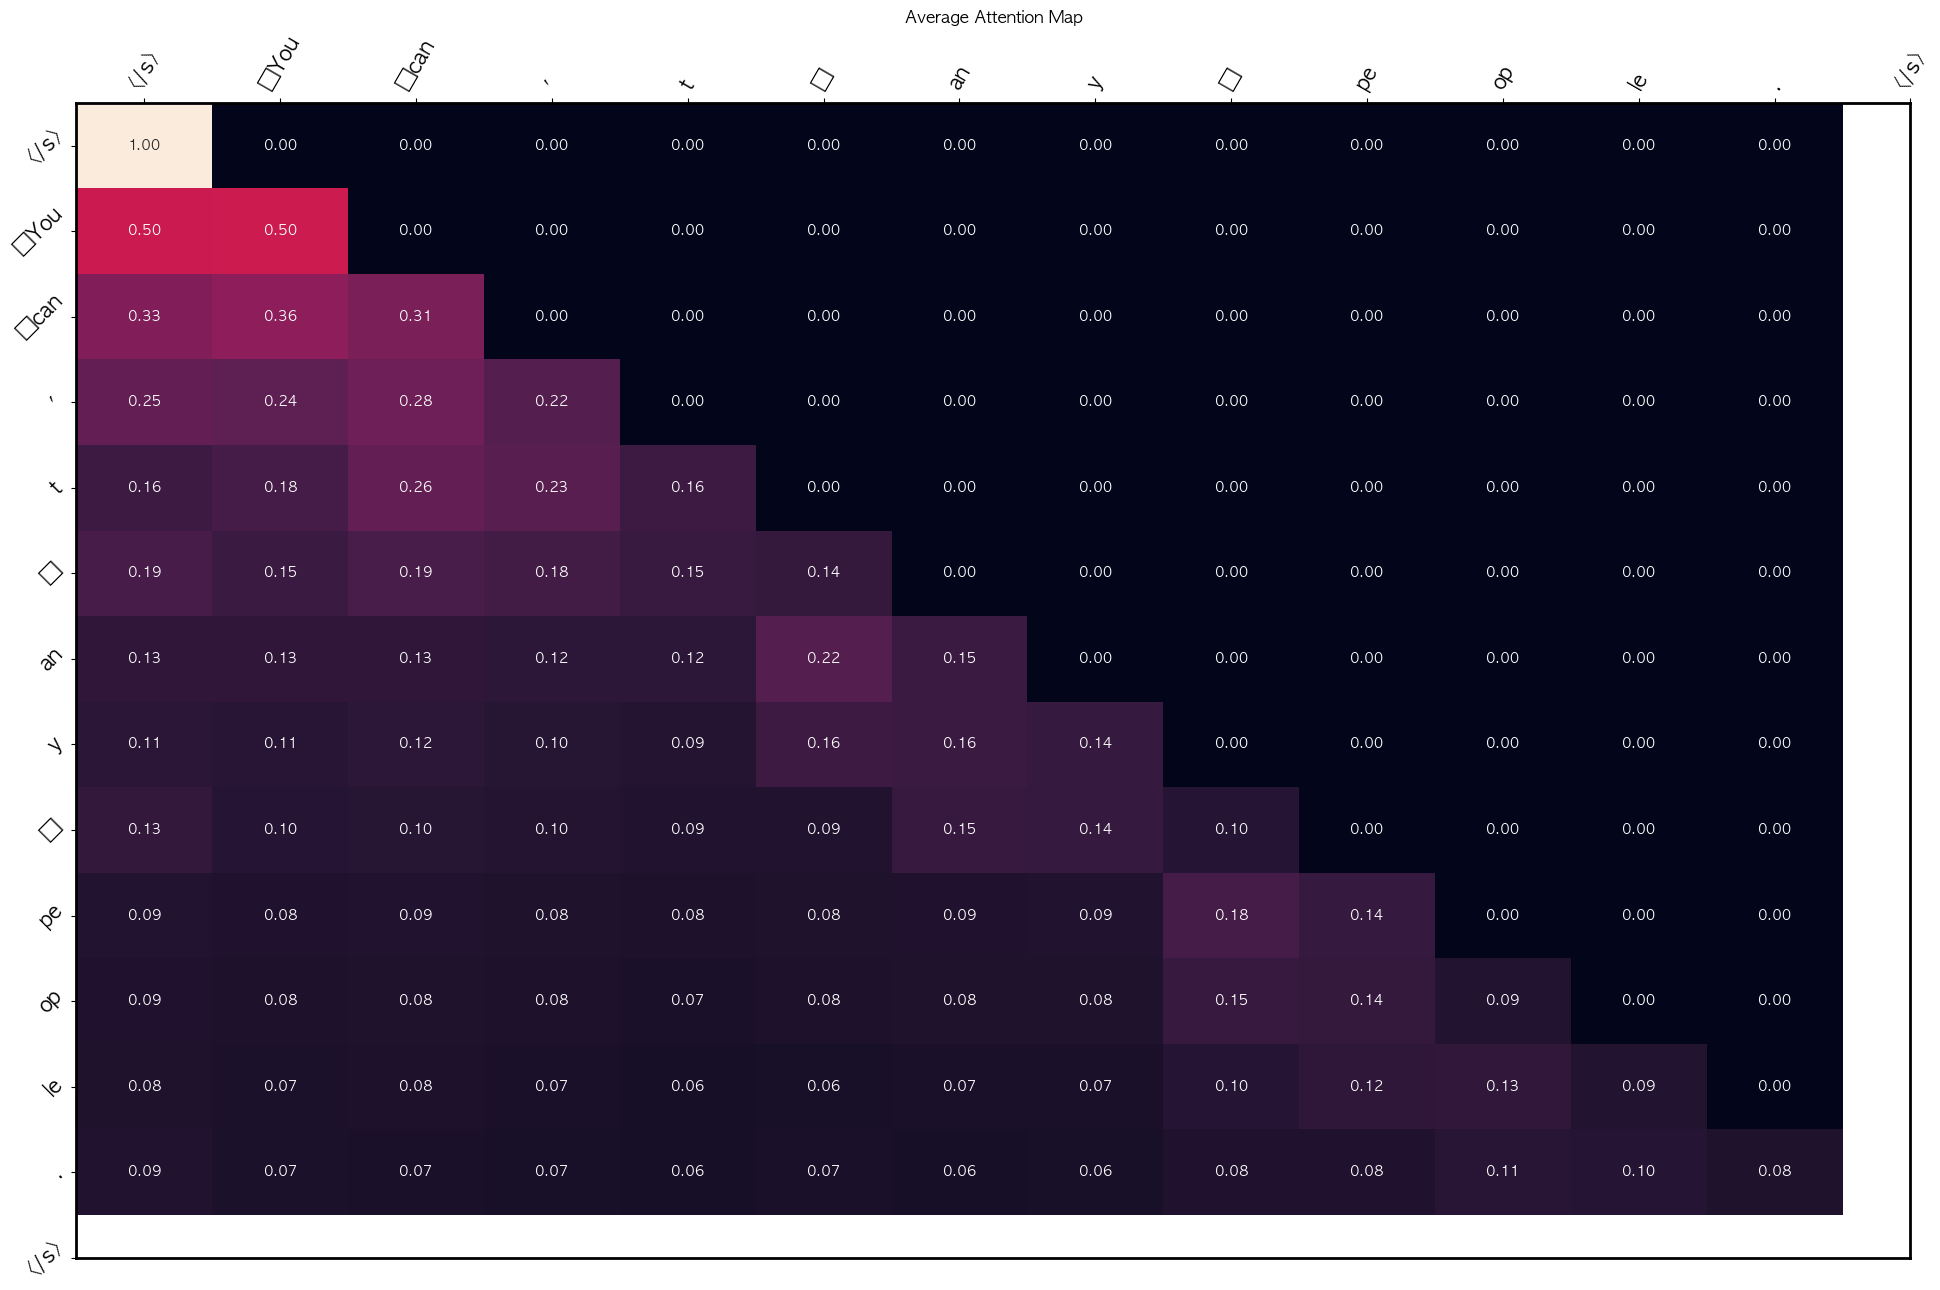

/Users/ball/Documents/workspace/transformer-tutorial/.venv/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) AppleGothic.
  fig.canvas.draw()
/var/folders/qc/krghrss90j3_h3x_kbbgxj740000gn/T/ipykernel_65554/45132878.py:38: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/ball/Documents/workspace/transformer-tutorial/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


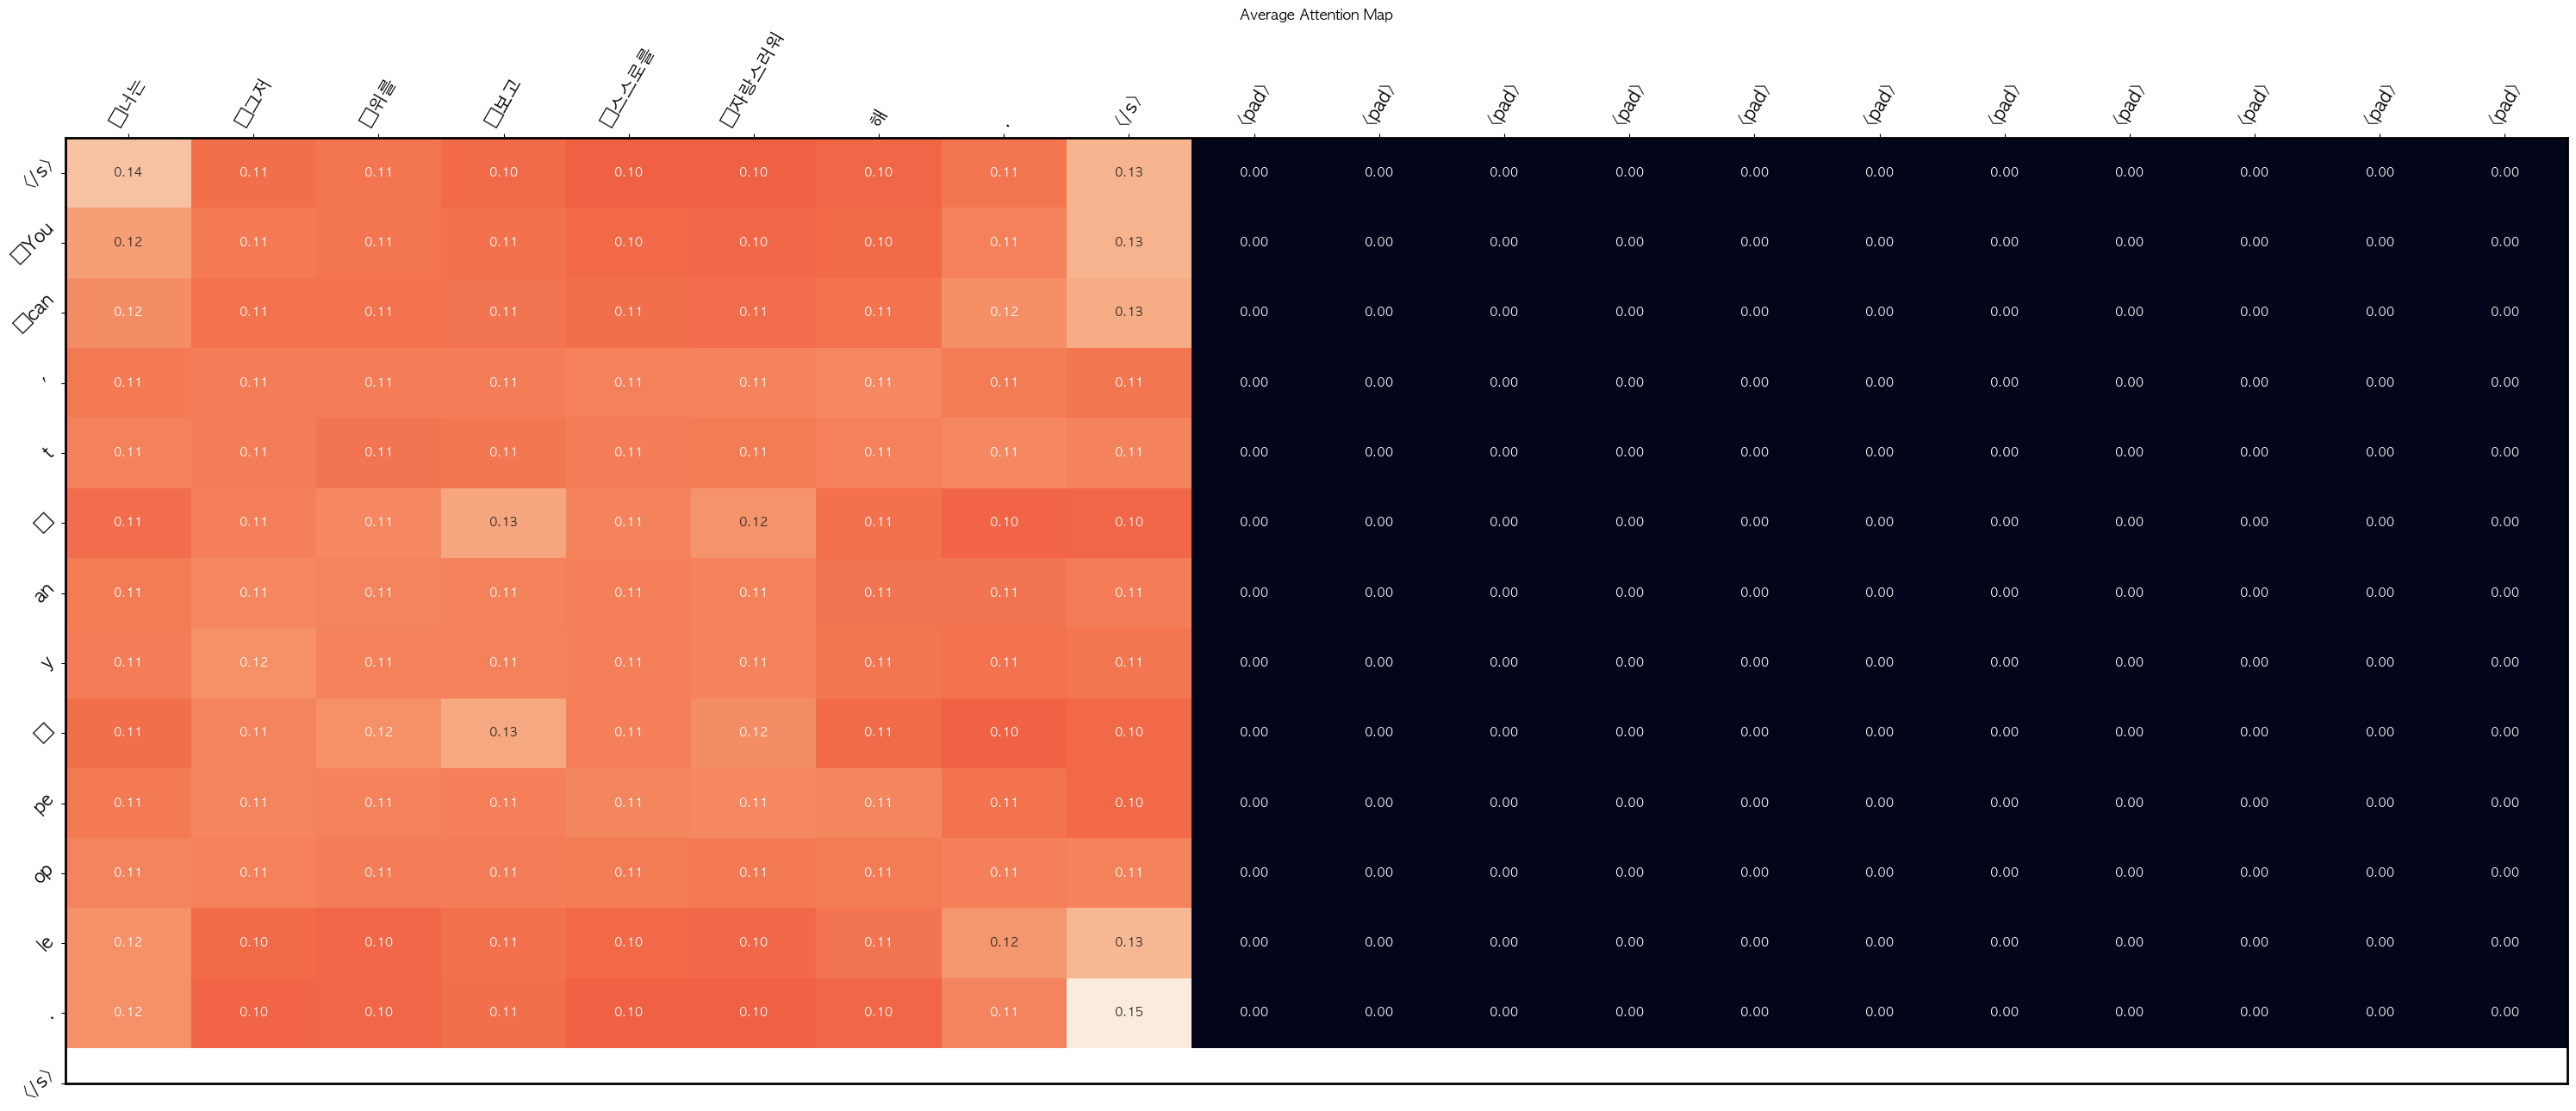

tensor([   0,   87,   67,   12,   49,    9, 1132,  350,    9, 6393, 4254, 1516,
           2,    0], device='mps:0')
</s> You can't any people.</s>


In [7]:
translated_sentence = inference("너는 그저 위를 보고 스스로를 자랑스러워해.")
print(translated_sentence)